# Classification - Bank Marketing

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Classification labels are unbalanced. Might be worth considering running through these metrics and techniques: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/. Also: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
# Import third party modules
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
import random

# For visualisations
shap.initjs()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# Remove 'Consider rewriting this model with the Functional API' warnings from Tensorflow
# These warnings can be ignored: https://github.com/tensorflow/recommenders/issues/188
tf.get_logger().setLevel('ERROR')

In [3]:
# Import custom modules
from metrics.sensitivity import calculate_sensitivity
from metrics.infidelity import calculate_infidelity

from model.metadata import get_feature_names, get_feature_names_of_type, append_indices, append_baselines
from model.feature_columns import get_normalization_parameters, create_numeric_columns, create_categorical_columns
from model.dataset_converter import convert_df_dataset, convert_dataframe_numpy, convert_numpy_tensor
from model.model_creation import create_fit_model

Sensitivity module imported
Dataset converter module imported
Metadata module imported
Infidelity module imported
Feature columns module imported


In [15]:
# Import data from csv
csv_file = 'data/classification-bank/bank-full.csv'
dataframe = pd.read_csv(csv_file, index_col=False, sep=';')

In [16]:
# Convert the Y value to 1 or 0
dataframe['y_binary'] = np.where(dataframe['y']=='yes', 1, 0)
dataframe.drop(['y'], axis=1, inplace=True)

In [17]:
# Convert day to strings (as this is really a categorical column):
dataframe['day'] = dataframe['day'].astype(str)

In [18]:
dataframe['day'][0]

'5'

In [19]:
# Sanity check
dataframe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y_binary
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [20]:
# Import metadata
import json
file = open('metadata.json')
metadata = json.load(file)

# Check this list aligns with the dataframe headers
df_headers = [f for f in dataframe]
for index, metadata_header in enumerate(metadata, start=0):
    assert(df_headers[index] == metadata_header['name'])
print('Confirm metadata aligns with dataframe')

Confirm metadata aligns with dataframe


In [11]:
# Append indexes to metadata
metadata = append_indices(metadata)
    
# Append baselines to metadata
    # Numerical: mean
    # Ordinal: mid-point of all values
    # Nominal: mode
metadata = append_baselines(metadata, dataframe)

In [5]:
# Add a random column to use to compare to more meaningful columns
dataframe['noise'] = np.random.randint(0,5, size=len(dataframe))

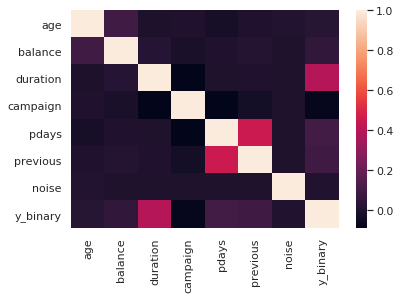

In [12]:
# Plot correlation matrix for numerical variables
# We can see [call] duration seems to have an impact on whether a loan is taken - this feels reasonable
corr = dataframe.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [13]:
# Split data (note this randomises the split so no stratification issues)
train_df, test_df = train_test_split(dataframe, test_size=0.2)
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,noise,y_binary
35326,48,blue-collar,married,secondary,yes,0,yes,yes,cellular,7,may,275,1,-1,0,unknown,2,0
19574,50,services,married,secondary,no,5569,no,no,cellular,7,aug,103,4,-1,0,unknown,1,0
9055,57,management,married,secondary,no,4046,no,yes,unknown,5,jun,331,1,-1,0,unknown,0,0
16946,25,blue-collar,married,secondary,no,59,yes,no,cellular,25,jul,246,1,-1,0,unknown,3,0
44686,38,management,single,tertiary,no,1027,yes,no,cellular,6,sep,387,2,188,3,success,4,0


In [14]:
batch_size = 100
train_ds = convert_df_dataset(train_df, 'y_binary', batch_size=batch_size)
test_ds = convert_df_dataset(test_df, 'y_binary', shuffle=False, batch_size=batch_size)

In [15]:
# Reset our feature columns
feature_columns = []

In [16]:
# Normalize and add numeric columns
# From: https://towardsdatascience.com/how-to-normalize-features-in-tensorflow-5b7b0e3a4177

# Get list of numeric columns
numeric_features_to_use = get_feature_names_of_type('numerical', metadata)

# Calculate mean and standard deviation (to feed into normalisation)
normalization_parameters = get_normalization_parameters(train_df, numeric_features_to_use)

# Get feature columns with built-in normaliser; add to list main list of columns
numeric_feature_columns = create_numeric_columns(train_df, numeric_features_to_use, normalization_parameters)
feature_columns += numeric_feature_columns

In [17]:
# Add indicator (one-hot) columns for categorical fields

nominal_features_to_use = get_feature_names_of_type('nominal', metadata)
ordinal_features_to_use = get_feature_names_of_type('ordinal', metadata)

categorical_features_to_use = nominal_features_to_use + ordinal_features_to_use

categorical_feature_columns = create_categorical_columns(train_df, categorical_features_to_use)
feature_columns += categorical_feature_columns

In [18]:
# Sanity check of feature columns
print(len(feature_columns))

15


In [19]:
# Use our feature columns to create an input layer (i.e. a mapping from the tf.data file)
input_layer = tf.keras.layers.DenseFeatures(feature_columns)
input_layer

In [65]:
# Create our model
model = tf.keras.Sequential([
  input_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(1, activation='sigmoid')
])


In [66]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [67]:
# Compile and train our model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)



In [68]:
example_model, example_history = create_fit_model(train_ds, input_layer, METRICS, epochs=3, verbose=0)

In [69]:
# Evaluate the overall accuracy of our model using the test set
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print("Test set accuracy", accuracy)

# Calculate percentage of y=0 values for comparison
y_zero = test_df['y_binary'].value_counts()[0]
y_one = test_df['y_binary'].value_counts()[1]
print(y_zero / (y_zero + y_one))

91/91 [==============================] - 2s 5ms/step - loss: 0.6601 - accuracy: 0.8785 - precision: 0.4683 - recall: 0.2032 - auc: 0.7440
Test set accuracy 0.8675101399421692
0.886873825058056


In [70]:
# Select an index value to predict/explain
index_to_explain = 388

In [71]:
# Allows us to predict a value for a specific instance
def predict_wrapper(model, instance, feature_names):
    input_tensor = convert_numpy_tensor(instance, feature_names)
    return model.predict(input_tensor)

feature_names = get_feature_names(metadata)
instance = convert_dataframe_numpy(dataframe, index_to_explain)
predict_wrapper(example_model, instance, feature_names)

array([[0.01821128]], dtype=float32)

In [72]:
# Set optimal constants for SHAP explanations
NUM_REFERENCE_VALUES = 50
NUM_PERTURBATIONS = 500

def shap_predictor_factory(feature_names, model):
    def predictor(instance):
        input_tensor = convert_numpy_tensor(instance, feature_names)
        return model.predict(input_tensor)
    return predictor

def get_explainer(predict_wrapper, dataframe_local, num_reference_values=50):
    # This never takes significant time - just calculating background values
    return shap.KernelExplainer(predict_wrapper, dataframe_local.iloc[:num_reference_values,:])

def generate_explanation(explainer, dataframe_local, index_to_explain, model_local, num_perturbations=500, chart=False, feature_names=[]):
    # Running time is O(num_reference_values * num_perturbations)
    global _shap_model
    _shap_model = model_local
    shap_values = explainer.shap_values(dataframe_local.iloc[index_to_explain,:], nsamples=num_perturbations)
    if chart == True:
        shap.summary_plot(np.array(shap_values), feature_names=feature_names, plot_type="bar")
    return shap_values

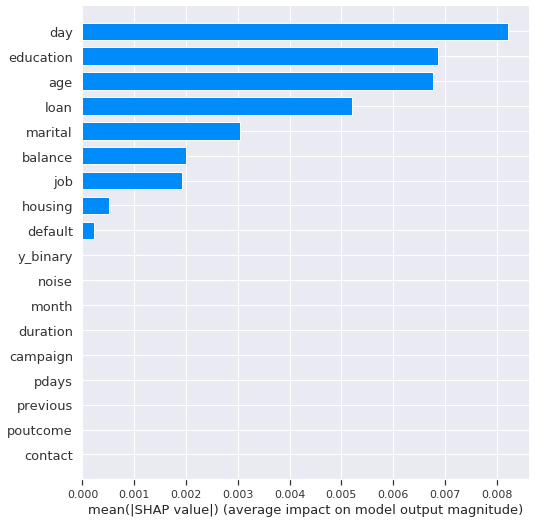

[array([-0.00677851, -0.00191695, -0.0030512 ,  0.00686615, -0.00022156,
        0.00199101, -0.00050988, -0.00519941,  0.        , -0.00821316,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])]


In [73]:
shap_predictor = shap_predictor_factory(feature_names, example_model)
example_explainer = get_explainer(shap_predictor, dataframe)
example_shap_values = generate_explanation(example_explainer, dataframe, index_to_explain, example_model, chart=True, feature_names=feature_names)
print(example_shap_values)

In [29]:
instance_for_metrics = convert_dataframe_numpy(dataframe, index_to_explain)[0]

In [31]:

example_explainer_simple = simple_explainer_factory(example_explainer)

sensitivity = calculate_sensitivity(example_explainer_simple, example_shap_values, instance_for_metrics, metadata)
sensitivity

0.23625538567615062

In [33]:

    
fidelity_model = fidelity_model_factory(example_model, feature_names)
infidelity = calculate_infidelity(example_shap_values[0], fidelity_model, instance_for_metrics, metadata)
infidelity

array([[7.2962255e-05]], dtype=float32)

### Evaluating SHAP Completeness Axion

Note - this is more part of the _metric_evaluation_ work, however needs a proper model so is living here for the time being.

This is important to show the fidelity numbers are meaningful - see Yeh at al.

In [74]:
baseline_index = 388
other_indexes = range(389, 410)

baseline_prediction = predict_wrapper(example_model, instance, feature_names)[0][0]
baseline_SV_sum = sum(example_shap_values[0])

completeness_results = pd.DataFrame(columns=['prediction_difference', 'SV_sum_difference'])

for idx in other_indexes:
    instance = convert_dataframe_numpy(dataframe, idx)
    prediction_difference = predict_wrapper(example_model, instance, feature_names)[0][0] - baseline_prediction
    SV_sum_difference = sum(generate_explanation(example_explainer, dataframe, idx, example_model, chart=False, feature_names=feature_names)[0]) - baseline_SV_sum
    completeness_results = completeness_results.append({
        'prediction_difference': prediction_difference,
        'SV_sum_difference': SV_sum_difference
    }, ignore_index=True)

[(-0.02, 0.04945229291915894)]

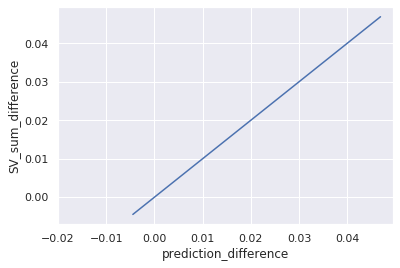

In [77]:
sns.lineplot(data=completeness_results, x="prediction_difference", y="SV_sum_difference", markers=True).set(xlim=-0.02)

### Overfitted model

Approach - try building models with 5 - 50 epochs (multiples of 5), with and without dropout. Compare metrics on TEST as well as training set. 

Hypothesis - models with higher epochs, and without dropout, will have higher accuracy on the training set but lower on test set. 

In [62]:
overfitting_results = pd.DataFrame(columns=['dropout', 'epochs', 'train_loss', 'train_accuracy', 'train_auc', 'test_loss', 'test_accuracy', 'test_auc'])


In [63]:
# With dropout
tf.get_logger().setLevel('ERROR')
for epochs in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50]:
    print(f'Calculating epoch: {epochs}')
    
    # With dropout
    model_with_dropout, history_with_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=True, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_with_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': True,
        'epochs': epochs,
        'train_loss': history_with_dropout.history['loss'][-1],
        'train_accuracy': history_with_dropout.history['accuracy'][-1],
        'train_auc': history_with_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)
    
    # Without dropout
    model_without_dropout, history_without_dropout = create_fit_model(train_ds, input_layer, METRICS, epochs=epochs, dropout=False, verbose=0)
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model_without_dropout.evaluate(test_ds)
    overfitting_results = overfitting_results.append({
        'dropout': False,
        'epochs': epochs,
        'train_loss': history_without_dropout.history['loss'][-1],
        'train_accuracy': history_without_dropout.history['accuracy'][-1],
        'train_auc': history_without_dropout.history['auc'][-1],
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc
    }, ignore_index=True)


Calculating epoch: 1
91/91 [==============================] - 1s 5ms/step - loss: 0.2938 - accuracy: 0.8917 - precision: 0.6246 - recall: 0.2088 - auc: 0.7906
Calculating epoch: 2
91/91 [==============================] - 1s 5ms/step - loss: 0.2927 - accuracy: 0.8882 - precision: 0.5462 - recall: 0.3155 - auc: 0.7911
Calculating epoch: 3
91/91 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8907 - precision: 0.5717 - recall: 0.2987 - auc: 0.7940
Calculating epoch: 4
91/91 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8914 - precision: 0.5915 - recall: 0.2603 - auc: 0.7902
Calculating epoch: 5
91/91 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8907 - precision: 0.5862 - recall: 0.2547 - auc: 0.7944
Calculating epoch: 6
91/91 [==============================] - 1s 5ms/step - loss: 0.2991 - accuracy: 0.8876 - precision: 0.5439 - recall: 0.3015 - auc: 0.7896
Calculating epoch: 7
91/91 [==================

In [64]:
overfitting_results

,dropout,epochs,train_loss,train_accuracy,train_auc,test_loss,test_accuracy,test_auc
0,True,1,0.321270,0.830448,0.719060,0.297430,0.893398,0.785512
1,False,1,0.313512,0.887815,0.755049,0.293771,0.891739,0.790568
2,True,2,0.298255,0.892833,0.772010,0.294068,0.892956,0.790837
3,False,2,0.289854,0.893442,0.789919,0.292658,0.888201,0.791140
4,True,3,0.292650,0.893027,0.785712,0.292476,0.890965,0.789249
5,False,3,0.284758,0.895598,0.799935,0.291155,0.890744,0.794025
6,True,4,0.287514,0.895101,0.796318,0.292295,0.890965,0.793562
7,False,4,0.279499,0.897534,0.810426,0.293729,0.891408,0.790192
8,True,5,0.283317,0.895958,0.804912,0.295180,0.892292,0.785340
9,False,5,0.274944,0.898087,0.819175,0.290631,0.890744,0.794396


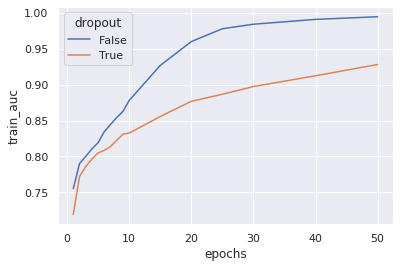

In [68]:
sns.lineplot(data=overfitting_results, x="epochs", y="train_auc", hue="dropout")

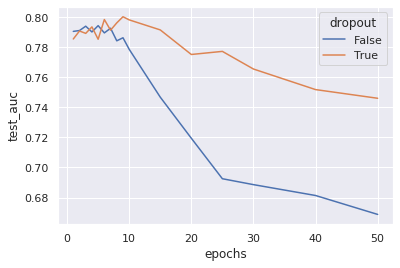

In [69]:
sns.lineplot(data=overfitting_results, x="epochs", y="test_auc", hue="dropout")